In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy import stats

In [2]:
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import GridSearchCV


In [3]:
df=pd.read_csv('cardio_train.csv',sep=";")
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


# Preprocessing

In [4]:
df.duplicated().sum()

np.int64(0)

In [5]:
df.isnull().sum()

,0
id,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0


In [6]:
df.dtypes

,0
id,int64
age,int64
gender,int64
height,int64
weight,float64
ap_hi,int64
ap_lo,int64
cholesterol,int64
gluc,int64
smoke,int64


In [7]:
# some preprocessing and feature engineer
df['age']=(df['age']/365.25).round()
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53.0,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,62.0,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52.0,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61.0,1,163,72.0,135,80,1,2,0,0,0,1


In [8]:
# Get all categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_columns)

Categorical Columns: Index([], dtype='object')


# Feature Engineering

In [9]:
df['bmi'] = df['weight'] / ((df['height']/100)**2)
df = df[(df['bmi'] >= 15) & (df['bmi'] <= 50)]

In [10]:
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['hypertension'] = ((df['ap_hi'] >= 140) | (df['ap_lo'] >= 90)).astype(int)
df['obesity'] = (df['bmi'] >= 30).astype(int)

df = df.drop(columns=['height', 'weight', 'ap_hi', 'ap_lo'])


<ipython-input-10-d805715d4f7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
<ipython-input-10-d805715d4f7b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hypertension'] = ((df['ap_hi'] >= 140) | (df['ap_lo'] >= 90)).astype(int)
<ipython-input-10-d805715d4f7b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [11]:
x = df.drop('cardio', axis = 1)
y = df['cardio']

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

In [13]:
pca=PCA(n_components=0.95)  # to  keep 95 the info the data
X_pca=pca.fit_transform(X_scaled)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=0)

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [16]:
from sklearn.naive_bayes import GaussianNB

In [17]:
model = GaussianNB()
model.fit(x_train, y_train)


y_pred = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.693317080166356

Confusion Matrix:
 [[5326 1578]
 [2699 4343]]

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.77      0.71      6904
           1       0.73      0.62      0.67      7042

    accuracy                           0.69     13946
   macro avg       0.70      0.69      0.69     13946
weighted avg       0.70      0.69      0.69     13946



In [18]:
from sklearn.model_selection import learning_curve


/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:513: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:514: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:514: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:513: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:514: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/usr/local/lib/python3.11/dist-packages/skl

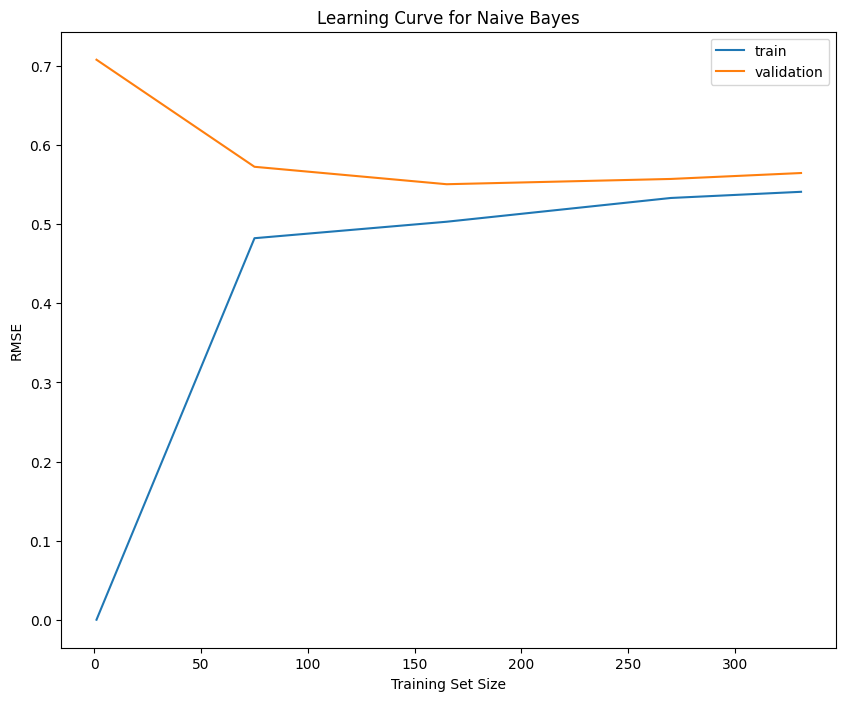

In [19]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=x_train,
    y=y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [1, 75, 165, 270, 331]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve for Naive Bayes")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

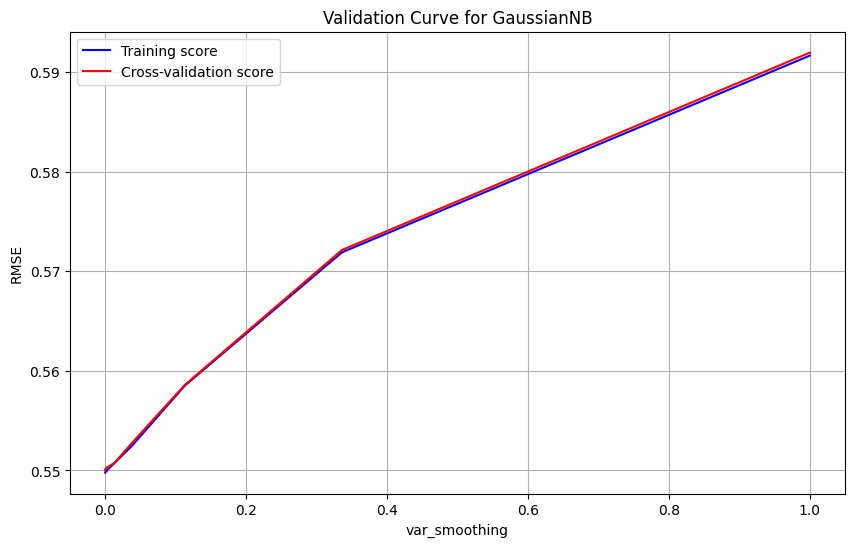

In [20]:
from sklearn.model_selection import validation_curve
import numpy as np

# Function to plot validation curves
def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=5, scoring="neg_root_mean_squared_error"):
    train_scores, test_scores = validation_curve(
        estimator=estimator,
        X=X,
        y=y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring=scoring
    )

    train_mean = -np.mean(train_scores, axis=1)
    test_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, label="Training score", color="blue")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="red")

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    plt.legend(loc="best")
    plt.grid()
    plt.show()
param_range = np.logspace(-9, 0, 20)
plot_validation_curve(model,
                     "Validation Curve for GaussianNB",
                     x_train,
                     y_train,
                     "var_smoothing",
                     param_range)

*As var_smoothing increases, the error goes up — performance drops.

*Training and validation scores stay close throughout, so no signs of overfitting.

*At higher values, the model gets too simple and starts missing patterns — underfitting kicks in.

/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:513: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:514: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:514: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:513: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:514: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/usr/local/lib/python3.11/dist-packages/skl

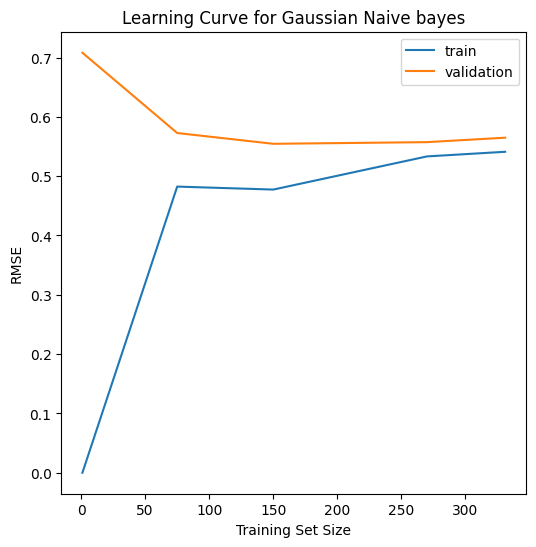

In [26]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=x_train,
    y=y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [1, 75, 150, 270, 331]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(6,6))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve for Gaussian Naive bayes")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

As Training size increase the rmse increase but training and test rmse ther gap small so somehow there is underfit

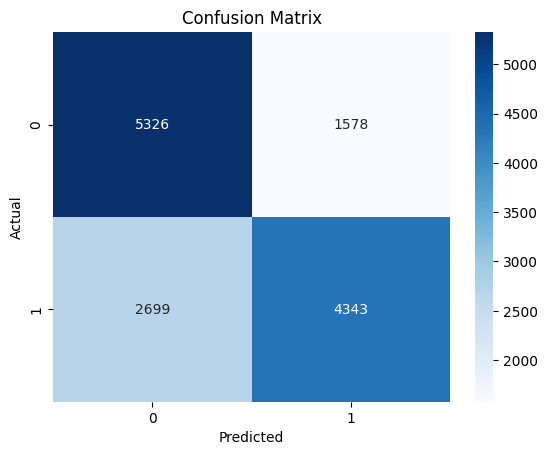

In [22]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

*The model is fairly balanced ,it's catching a good number of both 0s and 1s.

*However, it's making more mistakes with class 1:

*It misses 2699 actual 1s (false negatives).

*True positives and true negatives are strong, which is a good sign.

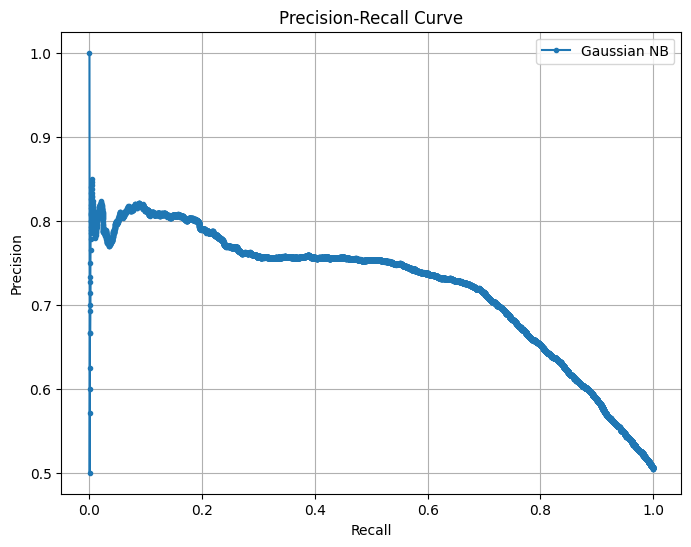

In [23]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc

# Generate predicted probabilities
y_probs_clf = model.predict_proba(x_test)[:, 1]

# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_clf)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker=".", label="Gaussian NB")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

Starts with high precision at very low recall meaning, early on, predictions are very accurate but very few positives are caught.

As recall increases, precision drops steadily and more positives are caught, but more false positives sneak in.

There's a trade-off: increasing recall usually decreases precision and vice versa.

To sum up, the curve stays above 0.7 precision until about 0.6 recall

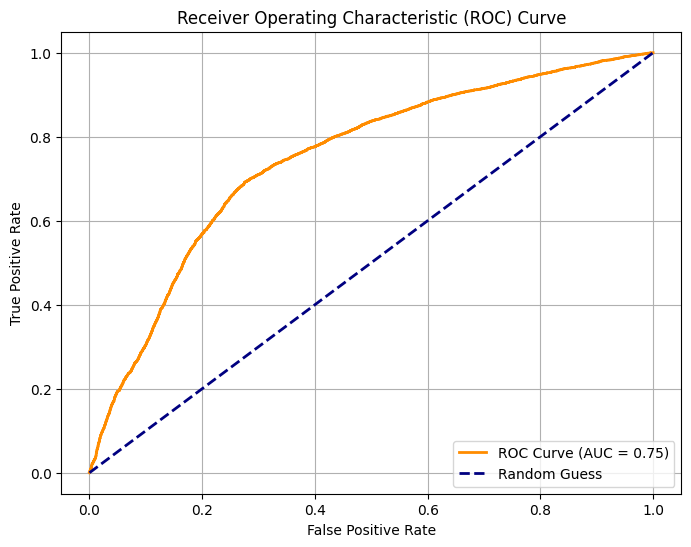

In [24]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_clf)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

AUC around 0.5: The model doesn’t learn any meaningful patterns i.e it is doing random guessing.